In [23]:
import pandas as pd
import numpy as np
import torch
import glob
import os
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


In [5]:
# Path to directory with spectral data
directory_path = 'spectral data/'

# Find matching name files
csv_files = glob.glob(os.path.join(directory_path, 'tc_2023-06-*_full_day.csv'))

# Loading CSVs into list of DataFrames
df_list = [pd.read_csv(file) for file in csv_files]

# Combine all df's into a single DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Show the first few rows
df_combined.head()

,dt_UTC01_NoDLS,300.0,301.0,302.0,303.0,304.0,305.0,306.0,307.0,308.0,...,1091.0,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0
0,2023-06-01 04:00:00,-0.03,0.01,-0.01,-0.03,-0.03,-0.02,-0.01,0.01,-0.02,...,0.56,0.06,0.29,1.15,1.06,0.39,0.27,-0.20,0.52,-1.39
1,2023-06-01 04:01:00,0.00,-0.01,-0.01,-0.02,0.02,-0.00,-0.01,-0.01,-0.01,...,-0.01,-0.30,0.18,-0.09,1.04,1.83,0.90,0.98,1.33,0.91
2,2023-06-01 04:02:00,0.00,-0.04,-0.02,-0.01,-0.01,0.00,0.00,-0.00,0.01,...,0.77,0.88,0.44,1.09,2.01,1.15,1.06,1.53,0.88,0.57
3,2023-06-01 04:03:00,0.00,0.04,0.03,0.02,0.05,0.04,0.02,0.03,0.02,...,0.00,-0.09,1.01,-0.33,0.58,0.52,-0.02,0.72,-0.13,0.47
4,2023-06-01 04:04:00,0.03,0.01,0.01,0.02,0.02,0.02,-0.01,0.00,-0.01,...,0.48,-0.14,0.66,0.76,0.71,0.11,-0.30,1.16,0.13,-0.87


In [6]:
print(df_combined.columns.tolist())

['dt_UTC01_NoDLS', '300.0', '301.0', '302.0', '303.0', '304.0', '305.0', '306.0', '307.0', '308.0', '309.0', '310.0', '311.0', '312.0', '313.0', '314.0', '315.0', '316.0', '317.0', '318.0', '319.0', '320.0', '321.0', '322.0', '323.0', '324.0', '325.0', '326.0', '327.0', '328.0', '329.0', '330.0', '331.0', '332.0', '333.0', '334.0', '335.0', '336.0', '337.0', '338.0', '339.0', '340.0', '341.0', '342.0', '343.0', '344.0', '345.0', '346.0', '347.0', '348.0', '349.0', '350.0', '351.0', '352.0', '353.0', '354.0', '355.0', '356.0', '357.0', '358.0', '359.0', '360.0', '361.0', '362.0', '363.0', '364.0', '365.0', '366.0', '367.0', '368.0', '369.0', '370.0', '371.0', '372.0', '373.0', '374.0', '375.0', '376.0', '377.0', '378.0', '379.0', '380.0', '381.0', '382.0', '383.0', '384.0', '385.0', '386.0', '387.0', '388.0', '389.0', '390.0', '391.0', '392.0', '393.0', '394.0', '395.0', '396.0', '397.0', '398.0', '399.0', '400.0', '401.0', '402.0', '403.0', '404.0', '405.0', '406.0', '407.0', '408.0', 

In [32]:
print(df_combined.index.name)

None


In [7]:
df_combined.set_index('dt_UTC01_NoDLS', inplace=True)

df_combined.shape

(12462, 801)

In [8]:
df_combined = df_combined.apply(pd.to_numeric, errors='coerce')
spectra = df_combined.dropna(axis=1, how='any')
print(spectra.dtypes)

300.0     float64
301.0     float64
302.0     float64
303.0     float64
304.0     float64
           ...   
1096.0    float64
1097.0    float64
1098.0    float64
1099.0    float64
1100.0    float64
Length: 801, dtype: object


In [9]:
spectra.shape

(12462, 801)

In [10]:
data_tensor = torch.tensor(spectra.values, dtype=torch.float32)
data_tensor

tensor([[-3.0000e-02,  1.0000e-02, -1.0000e-02,  ..., -2.0000e-01,
          5.2000e-01, -1.3900e+00],
        [ 0.0000e+00, -1.0000e-02, -1.0000e-02,  ...,  9.8000e-01,
          1.3300e+00,  9.1000e-01],
        [ 0.0000e+00, -4.0000e-02, -2.0000e-02,  ...,  1.5300e+00,
          8.8000e-01,  5.7000e-01],
        ...,
        [ 1.1860e+01,  1.5930e+01,  1.9840e+01,  ...,  4.7983e+02,
          4.7869e+02,  4.9213e+02],
        [ 1.0260e+01,  1.3440e+01,  1.8150e+01,  ...,  4.8536e+02,
          5.4142e+02,  5.0079e+02],
        [ 1.0470e+01,  1.5000e+01,  1.8300e+01,  ...,  5.0049e+02,
          5.0739e+02,  4.8445e+02]])

In [11]:
print("Tensor shape:", data_tensor.shape)  # (N, 801), where N is the number of time stamps

Tensor shape: torch.Size([12462, 801])


In [14]:
# Min-max normalization
min_vals = data_tensor.min(dim=0, keepdim=True).values
max_vals = data_tensor.max(dim=0, keepdim=True).values

# Avoid divide-by-zero by adding a small epsilon
normalized_tensor = (data_tensor - min_vals) / (max_vals - min_vals + 1e-8)


# Wrap data into a TensorDataset and DataLoader
dataset = TensorDataset(normalized_tensor)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

In [15]:

class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(801, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 6)
        )

        self.decoder = nn.Sequential(
            nn.Linear(6, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 801)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [16]:
net = DAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [17]:
criterion = nn.MSELoss
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001)

In [18]:
# Move model to device
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

# Training loop
n_epochs = 300
net.train()

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        inputs = batch[0].to(device)

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)  # Reconstruction loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)  # Weighted sum

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.6f}")


Epoch [1/300], Loss: 0.005317
Epoch [2/300], Loss: 0.000284
Epoch [3/300], Loss: 0.000286
Epoch [4/300], Loss: 0.000773
Epoch [5/300], Loss: 0.000267
Epoch [6/300], Loss: 0.000208
Epoch [7/300], Loss: 0.000122
Epoch [8/300], Loss: 0.000114
Epoch [9/300], Loss: 0.000109
Epoch [10/300], Loss: 0.000108
Epoch [11/300], Loss: 0.000581
Epoch [12/300], Loss: 0.000108
Epoch [13/300], Loss: 0.000105
Epoch [14/300], Loss: 0.000099
Epoch [15/300], Loss: 0.000102
Epoch [16/300], Loss: 0.000113
Epoch [17/300], Loss: 0.000146
Epoch [18/300], Loss: 0.000066
Epoch [19/300], Loss: 0.000049
Epoch [20/300], Loss: 0.000057
Epoch [21/300], Loss: 0.000079
Epoch [22/300], Loss: 0.000054
Epoch [23/300], Loss: 0.000073
Epoch [24/300], Loss: 0.000258
Epoch [25/300], Loss: 0.000040
Epoch [26/300], Loss: 0.000040
Epoch [27/300], Loss: 0.000040
Epoch [28/300], Loss: 0.000048
Epoch [29/300], Loss: 0.000042
Epoch [30/300], Loss: 0.000278
Epoch [31/300], Loss: 0.000045
Epoch [32/300], Loss: 0.000042
Epoch [33/300], L

In [19]:
net.eval()

# Move normalized input to device
with torch.no_grad():
    latent_representations = net.encoder(normalized_tensor.to(device))

# Move to CPU and convert to numpy if needed
latent_representations = latent_representations.cpu()

print("Latent shape:", latent_representations.shape)  # Should be (60, 6)
print("Device", latent_representations.device)

Latent shape: torch.Size([12462, 6])
Device cpu


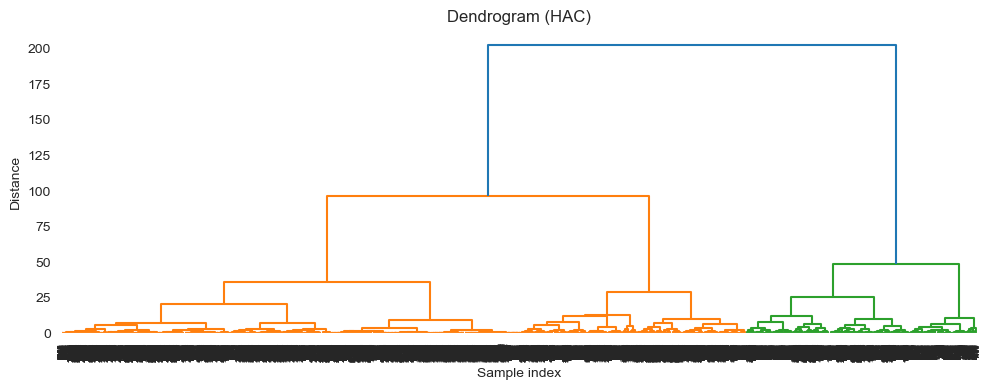

In [24]:


# Convert to numpy if not already
latent_np = latent_representations.numpy()

# Optional: dendrogram visualization (just for fun)
linked = linkage(latent_np, method='ward')
plt.figure(figsize=(10, 4))
# dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           labels=np.arange(len(latent_np)))

plt.title("Dendrogram (HAC)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

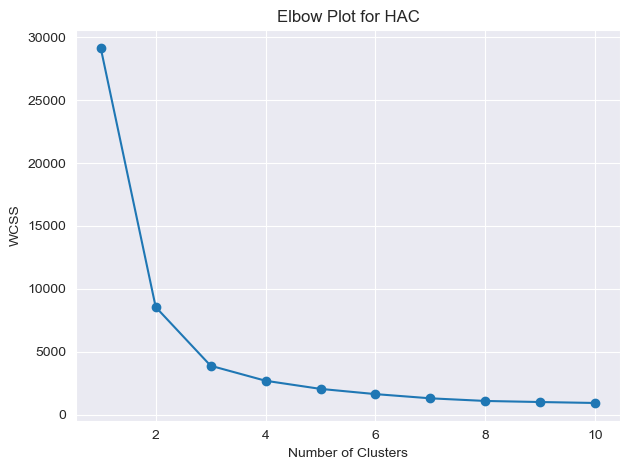

In [25]:

wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(latent_np)

    # Compute WCSS manually
    wcss_k = 0
    for cluster_id in np.unique(labels):
        cluster_points = latent_np[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distances = np.sum((cluster_points - centroid) ** 2)
        wcss_k += distances

    wcss.append(wcss_k)

# Plot WCSS (elbow)
plt.figure()
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Plot for HAC")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:


# HAC with 5 clusters
hac_5 = AgglomerativeClustering(n_clusters=5)
cluster_labels = hac_5.fit_predict(latent_np)

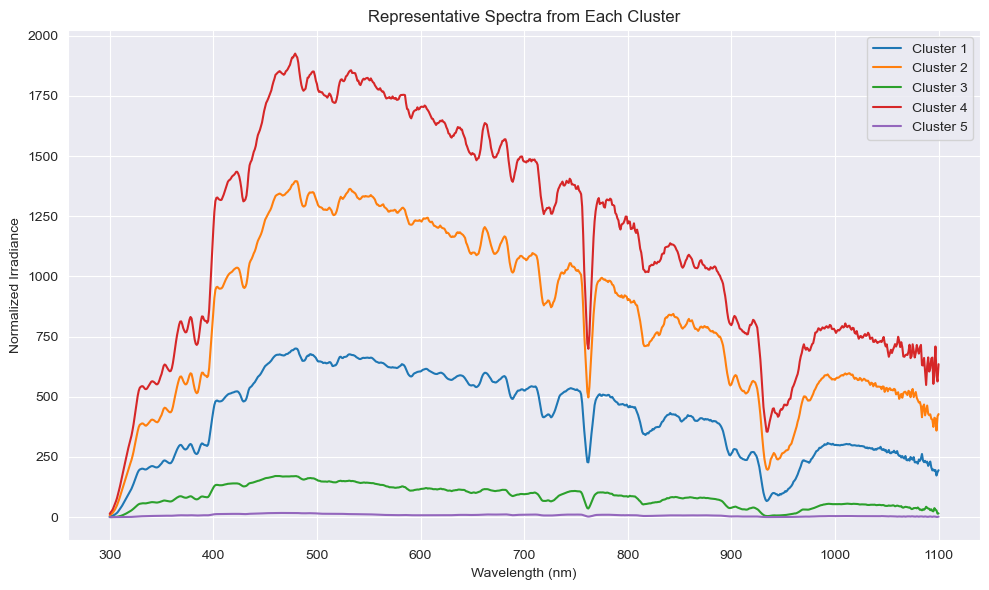

In [31]:

representative_indices = []

for cluster_id in np.unique(cluster_labels):
    # Step 1: Get indices of samples in this cluster
    cluster_idx = np.where(cluster_labels == cluster_id)[0]
    cluster_latents = latent_np[cluster_idx]

    # Step 2: Compute pairwise distances within the cluster
    pairwise_dists = cdist(cluster_latents, cluster_latents, metric='euclidean')

    # Step 3: Sum distances for each sample
    sum_dists = pairwise_dists.sum(axis=1)

    # Step 4: Select index with minimum total distance
    rep_idx_within_cluster = np.argmin(sum_dists)
    rep_idx = cluster_idx[rep_idx_within_cluster]
    representative_indices.append(rep_idx)

# Step 5: Get the corresponding original spectra (denormalized if needed)
rep_spectra = data_tensor[representative_indices].cpu().numpy()

# Step 6: Plot the representative spectra
plt.figure(figsize=(10, 6))
#wavelengths = spectra['Wavelength'].values  # original x-axis
wavelengths = np.arange(300, 1101)

for i, spec in enumerate(rep_spectra):
    plt.plot(wavelengths, spec, label=f'Cluster {i+1}')

plt.title('Representative Spectra from Each Cluster')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()